In [44]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from salad.models.phase1 import Phase1Model
from salad.models.phase2 import Phase2Model
from salad.models.language_phase1 import LangPhase1Model
from salad.models.language_phase2 import LangPhase2Model
from omegaconf import OmegaConf
import hydra
from salad.model_components.network import UnCondDiffNetwork, CondDiffNetwork
from salad.utils import visutil, imageutil
from salad.utils.spaghetti_util import *
from typing import Literal
from pytorch_lightning import seed_everything
device = "cuda:2"

def load_model(category: Literal["airplane", "chair", "table"], model_class: Literal["phase1", "phase2"], device):
    c = OmegaConf.load(f"../checkpoints/{category}/{model_class}/hparams.yaml")
    model = hydra.utils.instantiate(c)
    ckpt = torch.load(f"../checkpoints/{category}/{model_class}/state_only.ckpt")
    model.load_state_dict(ckpt)
    model.eval()
    for p in model.parameters(): p.requires_grad_(False)
    model = model.to(device)
    return model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load SPAGHETTI and Mesher

In [40]:
spaghetti = load_spaghetti(device=device, tag="airplanes") # "chairs_large" or "tables"
mesher = load_mesher(device=device)

loading spaghetti model from /home/juil/projects/salad/salad/spaghetti/assets/checkpoints/spaghetti_airplanes/model


# Load models

In [17]:
from salad.utils import sysutil
from collections import OrderedDict

sysutil.clean_gpu()

In [45]:
phase1_model = load_model("airplane", "phase1", device)
phase2_model = load_model("airplane", "phase2", device)

# Sample extrinsic parameters and intrinsic latents.

In [46]:
seed_everything(63)

# phase1 sampling
extrinsics = phase1_model.sampling_gaussians(4)

# phase2 sampling
intrinsics = phase2_model.sample(extrinsics)

zcs = generate_zc_from_sj_gaus(spaghetti, intrinsics, extrinsics)

Global seed set to 63


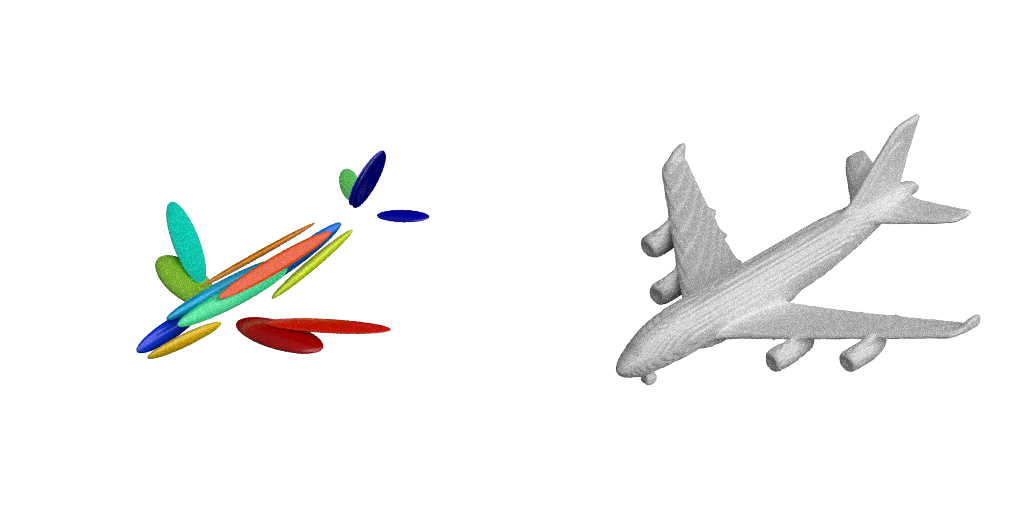

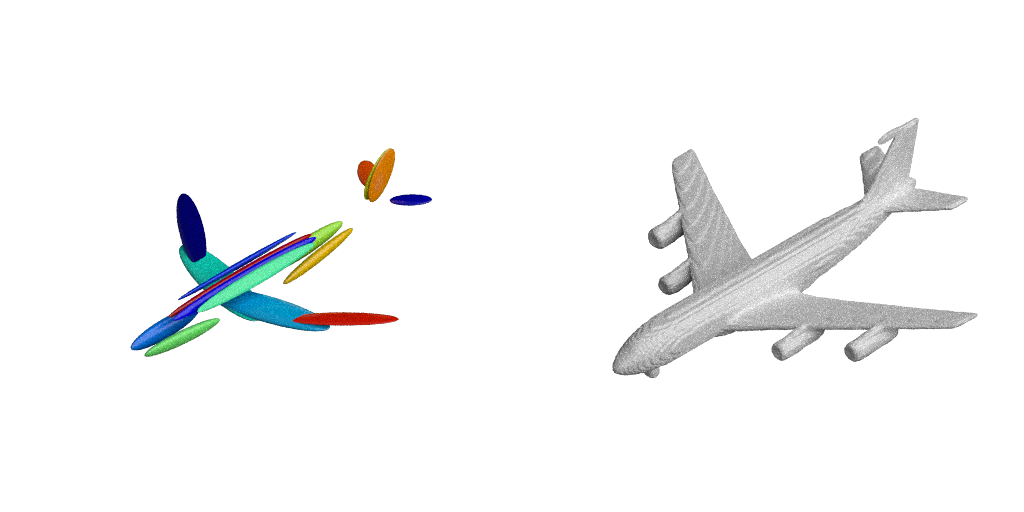

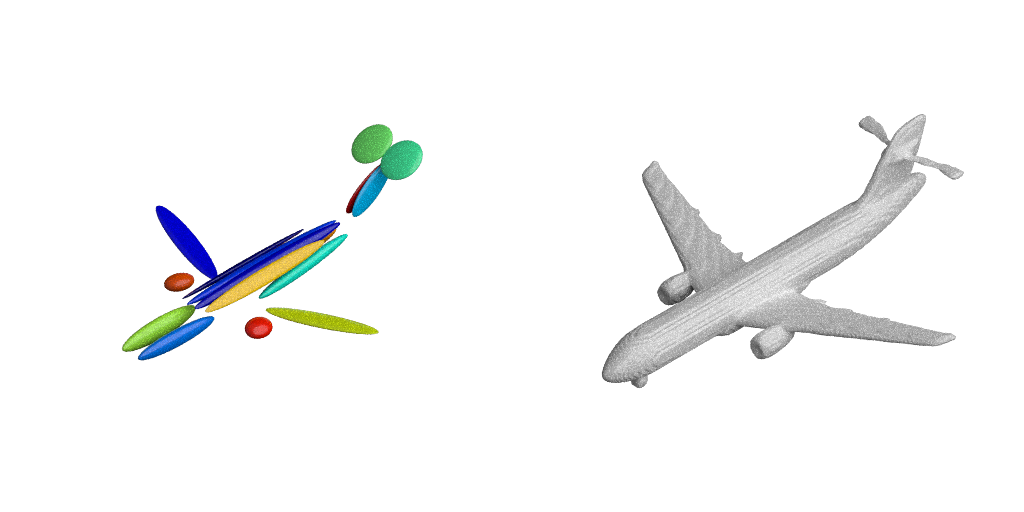

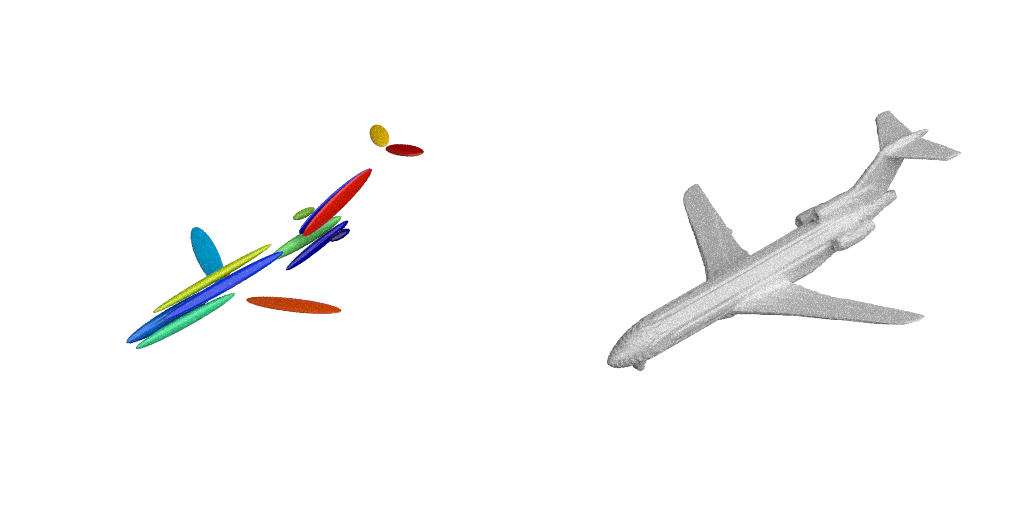

In [47]:
# visualize
for i in range(len(zcs)):
    gaus_img = visutil.render_gaussians(extrinsics[i])
    
    v, f = get_mesh_from_spaghetti(spaghetti, mesher, zcs[i], res=256)
    mesh_img = visutil.render_mesh(v, f)
    
    img = imageutil.merge_images([gaus_img, mesh_img])
    display(img)